In [1]:
# Song Liu (song.liu@bristol.ac.uk), 01-06-2023
# All rights reserved.

# load csv files from archive folder
import matplotlib.pyplot as plt
from numpy import  *
import pandas as pd

base = pd.read_csv('Variant I.csv')
income = base['income']
age = base['customer_age']
employment = base['employment_status']
# remove 'income', 'customer_age', 'employment_status' columns as they are protected
# base = base.drop(columns=['income', 'customer_age', 'employment_status'])
# convert categorical variables in 'payment_type' to integers
base['employment_status'] = base['employment_status'].astype('category')
base['payment_type'] = base['payment_type'].astype('category')

base['housing_status'] = base['housing_status'].astype('category')
base['source'] = base['source'].astype('category')
base['device_os'] = base['device_os'].astype('category')

cat_columns = base.select_dtypes(['category']).columns
base[cat_columns] = base[cat_columns].apply(lambda x: x.cat.codes)
df = base
base = base.to_numpy()

# class prior 
prior = sum(base[:,0])/len(base)

print('class prior for positive:', prior)
print('class prior for negative:', 1-prior)

class prior for positive: 0.011029
class prior for negative: 0.988971


Text(0, 0.5, 'True Positive Rate')

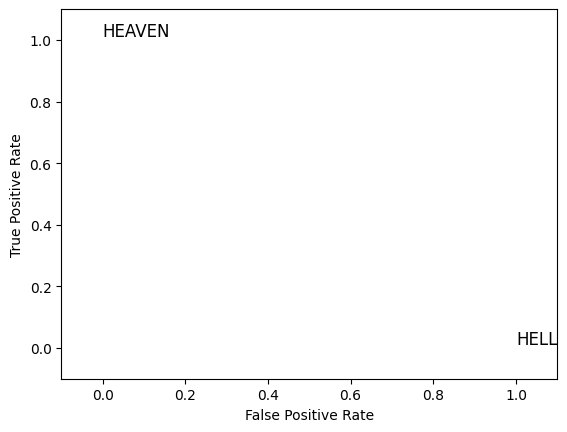

In [2]:
def TPR(pred, label):
    TP = sum((pred==1) & (label==1))
    FN = sum((pred==0) & (label==1))
    return TP/(TP+FN)

def FPR(pred, label):
    FP = sum((pred==1) & (label==0))
    TN = sum((pred==0) & (label==0))
    return FP/(FP+TN)

# text on the plot
plt.text(1, 0, 'HELL', fontsize=12, verticalalignment='bottom')
plt.text(0, 1, 'HEAVEN', fontsize=12, verticalalignment='bottom')

# visualize the ROC space
plt.xlim(-.1,1.1); plt.ylim(-.1,1.1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Text(0, 0.5, 'True Positive Rate')

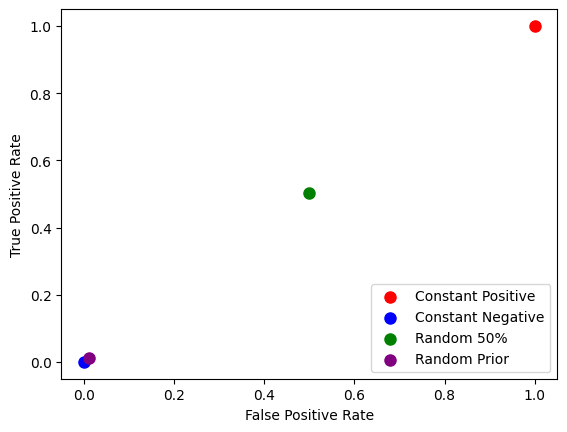

In [3]:
label = base[:,0]

# see how a constant positive classifier will perform 
TPR_constpos = TPR(ones(len(base)), label)
FPR_constpos = FPR(ones(len(base)), label)

# see how a constant negative classifier will perform
TPR_constneg = TPR(zeros(len(base)), label)
FPR_constneg = FPR(zeros(len(base)), label)

plt.scatter(FPR_constpos, TPR_constpos, 64, color = 'red', marker = 'o', label = 'Constant Positive')
plt.scatter(FPR_constneg, TPR_constneg, 64, color = 'blue', marker = 'o', label = 'Constant Negative')

# a random classifier, which will pick positive 50 percent of the time
pred = random.rand(len(base)) > .5

TPR_rand = TPR(pred, label)
FPR_rand = FPR(pred, label)

plt.scatter(FPR_rand, TPR_rand, 64, color = 'green', marker = 'o', label = 'Random 50%')

# a random classifier, which will pick positive according to the class prior
pred = random.rand(len(base)) < prior
TPR_rand2 = TPR(pred, label)
FPR_rand2 = FPR(pred, label)
plt.scatter(FPR_rand2, TPR_rand2, 64, color = 'purple', marker = 'o', label = 'Random Prior')
plt.legend(loc = 'lower right')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [4]:
def roc(pred, label):
    fpr, tpr = [], []
    tmax = max(pred)
    tmin = min(pred)
    for t in linspace(tmin, tmax, 100):
        p = pred > t
        tpr.append(TPR(p, label))
        fpr.append(FPR(p, label))
    return fpr, tpr

def AUC(fpr, tpr):
    return sum([(tpr[i]+tpr[i-1])*(fpr[i-1]-fpr[i])/2 for i in range(1, len(fpr))])

# train a logistic regression using sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = base[:,1:]
y = base[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# not weighted
clf0 = LogisticRegression(random_state=0, max_iter = 100).fit(X_train, y_train, sample_weight = None)
# weight the samples according to the class prior
weights = y_train*(1-prior) + (1-y_train)*prior
clf1 = LogisticRegression(random_state=0, max_iter = 100).fit(X_train, y_train, sample_weight = weights)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Text(0, 0.5, 'True Positive Rate')

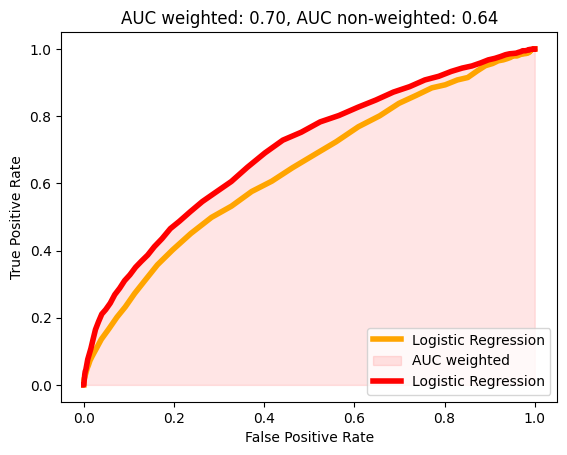

In [5]:
y_score0 = clf0.decision_function(X_test)
fpr0, tpr0 = roc(y_score0, y_test)
y_score1 = clf1.decision_function(X_test)
fpr1, tpr1 = roc(y_score1, y_test)

plt.plot(fpr0, tpr0, color = 'orange', label = 'Logistic Regression', linewidth = 4)

# plot the histogram under the curve
plt.fill_between(fpr1, tpr1, color = 'red', alpha = .1, label = 'AUC weighted')
plt.plot(fpr1, tpr1, color = 'red', label = 'Logistic Regression', linewidth = 4)
plt.title('AUC weighted: %0.2f, AUC non-weighted: %0.2f' % (AUC(fpr1, tpr1), AUC(fpr0, tpr0)))
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

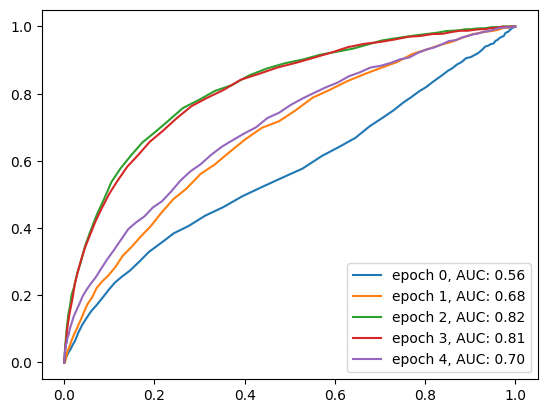

In [8]:
import pylab as pl
from IPython import display

# Let us maximize the AUC
import torch # bring out the big gun

def aucloss(pred, label):
    if pred[label==1].shape[0] == 0: # you might end up with no positive samples
        print('no positive samples!')
    pos_pred = pred[label==1]
    neg_pred = pred[label==0]
    
    # hinge loss
    T = (neg_pred.T - pos_pred)
    loss = torch.max(T, torch.zeros_like(T))/2
    loss = torch.mean(loss, dim = 0)
    loss = torch.mean(loss)
    return loss

# same linear model
class NN(torch.nn.Module):
    def __init__(self, d):
        super(NN, self).__init__()
        self.fc = torch.nn.Linear(d, 1)
        
    def forward(self, x):
        return self.fc(x)

X_tr = torch.tensor(X_train, dtype = torch.float32)
y_tr = torch.tensor(y_train, dtype = torch.float32)
X_te = torch.tensor(X_test, dtype = torch.float32)
y_te = torch.tensor(y_test, dtype = torch.float32)

dataset = torch.utils.data.TensorDataset(X_tr, y_tr)
trainload = torch.utils.data.DataLoader(dataset, batch_size = 10000, shuffle = True)

model = NN(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(5):
    for x, y in trainload:
        optimizer.zero_grad()
        pred = model(x)
        loss = aucloss(pred, y)
        
        loss.backward()
        optimizer.step()
    
    pred_te = model(X_te).detach().numpy()[:,0]

    fpr, tpr = roc(pred_te, y_test)
    auc = AUC(fpr, tpr)
    
    pl.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
    pl.legend(loc = 'lower right')
    display.display(pl.gcf())
    display.clear_output(wait=True)


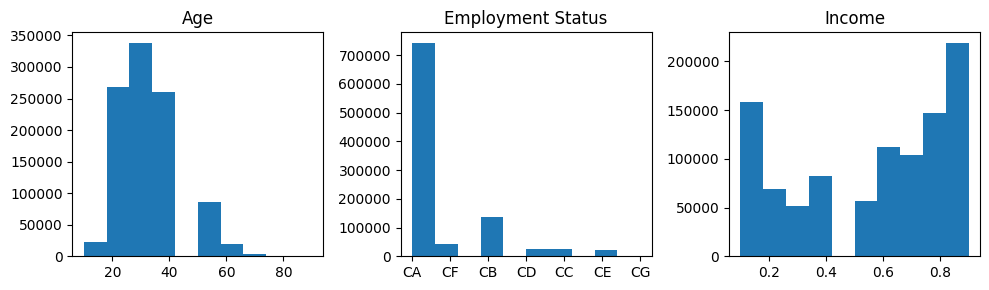

In [6]:
fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].hist(age)
ax[0].set_title("Age")

ax[1].hist(employment)
ax[1].set_title('Employment Status')

ax[2].hist(income)
ax[2].set_title('Income')

plt.tight_layout()

In [7]:
def accuracy(y, y_p):
    return sum([y[i]==y_p[i] for i in range(len(y))])/len(y)

def recall(y, y_p):
    return sum([y_p[i]==1 if y[i]==1 else 0 for i in range(len(y))])/len([i for i in y if i==1])

In [46]:
def fpr(y_p, y):
    return sum([y_p[i] == 1 and y[i] == 0 for i in range(len(y))])/sum([1 for i in y if i==0])

def tpr(y_p, y):
    return sum([y_p[i] == 1 and y[i] == 1 for i in range(len(y))])/sum([1 for i in y if i==1])

def tnr(y_p, y):
    return sum([y_p[i] == 0 and y[i] == 0 for i in range(len(y))])/sum([1 for i in y if i==0])

def fnr(y_p, y):
    return sum([y_p[i] == 0 and y[i] == 1 for i in range(len(y))])/sum([1 for i in y if i==1])

Start with income as an indicator

The below code is adapted from the AIF360 library:

https://github.com/Trusted-AI/AIF360/blob/main/aif360/algorithms/postprocessing/eq_odds_postprocessing.py

In [67]:
X = df.drop(["indicator", "fraud_bool"], axis=1)
y = df["fraud_bool"]
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [90]:
prior = sum(y_train)/len(y_train)
weights = y_train*(1-prior) + (1-y_train)*prior

In [91]:
clf = LogisticRegression()
clf.fit(X_train, y_train, sample_weight=weights)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [92]:
y_decision = clf.decision_function(X_test)
y_probs = clf.predict_proba(X_test)

In [99]:
y_p = array([int(prob > t) for prob in y_probs[:,1]])

In [115]:
pred_df = X_test
pred_df["pred"] = y_p
pred_df["indicator"] = df['indicator'][pred_df.index]
pred_df["decision"] = y_decision

In [119]:
# calculate the rates amongst different groups
# sorry for "== False" I don't know how else to do it!

fpr_curve0, tpr_curve0 = roc(pred_df["decision"][pred_df['indicator']==False], y_test[pred_df['indicator']==False])
fpr_curve1, tpr_curve1 = roc(pred_df["decision"][pred_df['indicator']], y_test[pred_df['indicator']])

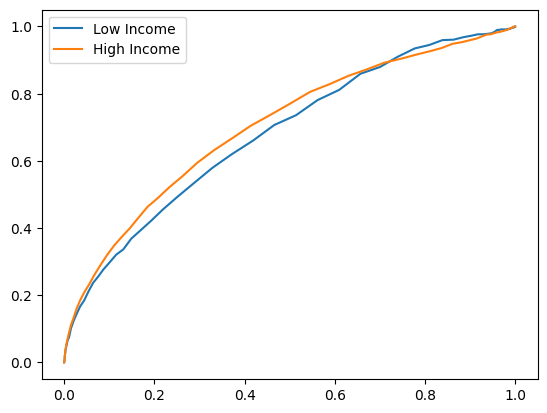

In [120]:
plt.plot(fpr_curve0, tpr_curve0, label="Low Income")
plt.plot(fpr_curve1, tpr_curve1, label="High Income")
plt.legend()

In [227]:
# define rates for each protected attribute value

index0 = pred_df['indicator']
index1 = logical_not(pred_df['indicator'])

fpr0 = fpr(list(pred_df["pred"][index0]), list(y_test[index0]))
fpr1 = fpr(list(pred_df["pred"][index1]), list(y_test[index1]))

tpr0 = tpr(list(pred_df["pred"][index0]), list(y_test[index0]))
tpr1 = tpr(list(pred_df["pred"][index1]), list(y_test[index1]))

fnr0 = fnr(list(pred_df["pred"][index0]), list(y_test[index0]))
fnr1 = fnr(list(pred_df["pred"][index1]), list(y_test[index1]))

tnr0 = tnr(list(pred_df["pred"][index0]), list(y_test[index0]))
tnr1 = tnr(list(pred_df["pred"][index1]), list(y_test[index1]))

In [228]:
# set up parameter array

c = array([fpr0 - tpr0, tnr0 - fnr0, fpr1 - tpr1, tnr1 - fnr1])


# constraints for optimisation

A_ub = array([[ 1,  0,  0,  0],
                 [-1,  0,  0,  0],
                 [ 0,  1,  0,  0],
                 [ 0, -1,  0,  0],
                 [ 0,  0,  1,  0],
                 [ 0,  0, -1,  0],
                 [ 0,  0,  0,  1],
                 [ 0,  0,  0, -1]], dtype=float64)
b_ub = array([1, 0, 1, 0, 1, 0, 1, 0], dtype=float64)

In [230]:
# which of the predicted values in each attribute are 1 or 0
# will be used for rate calculation
sconst = ravel(y_p[index0] == 1)
sflip = ravel(y_p[index0] == 0)
oconst = ravel(y_p[index1] == 1)
oflip = ravel(y_p[index1] == 0)

In [231]:
# calculate number of tn, fn, fp, tp for each class
# s is indicator is true (A=1), o is false (A=0)
sm_tn = logical_and(sflip,
    y_test[index0] == 0,
    ).astype(float64)
sm_fn = logical_and(sflip,
    y_test[index0] == 1,
    ).astype(float64)
sm_fp = logical_and(sconst,
    y_test[index0] == 0,
    ).astype(float64)
sm_tp = logical_and(sconst,
    y_test[index0] == 1,
    ).astype(float64)

om_tn = logical_and(oflip,
    y_test[index1] == 0,
    ).astype(float64)
om_fn = logical_and(oflip,
    y_test[index1] == 1,
    ).astype(float64)
om_fp = logical_and(oconst,
    y_test[index1] == 0,
    ).astype(float64)
om_tp = logical_and(oconst,
    y_test[index1] == 1,
    ).astype(float64)

In [232]:
# base probabilties
obr = sum(y_test[index1])/len(y_test[index1])
sbr = sum(y_test[index0])/len(y_test[index0])

In [241]:
# equality constraints

A_eq = [[(mean(sconst*sm_tp) - mean(sflip*sm_tp)) / sbr,
         (mean(sflip*sm_fn) - mean(sconst*sm_fn)) / sbr,
         (mean(oflip*om_tp) - mean(oconst*om_tp)) / obr,
         (mean(oconst*om_fn) - mean(oflip*om_fn)) / obr],
        [(mean(sconst*sm_fp) - mean(sflip*sm_fp)) / (1-sbr),
         (mean(sflip*sm_tn) - mean(sconst*sm_tn)) / (1-sbr),
         (mean(oflip*om_fp) - mean(oconst*om_fp)) / (1-obr),
         (mean(oconst*om_tn) - mean(oflip*om_tn)) / (1-obr)]]

b_eq = [(mean(oflip*om_tp) + mean(oconst*om_fn)) / obr
      - (mean(sflip*sm_tp) + mean(sconst*sm_fn)) / sbr,
        (mean(oflip*om_fp) + mean(oconst*om_tn)) / (1-obr)
      - (mean(sflip*sm_fp) + mean(sconst*sm_tn)) / (1-sbr)]

In [242]:
from scipy.optimize import linprog

In [243]:
# solve the linear program
model_params = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq)

In [244]:
model_params

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -0.47793974628737035
              x: [ 8.337e-01  0.000e+00  1.000e+00  8.436e-03]
            nit: 2
          lower:  residual: [ 8.337e-01  0.000e+00  1.000e+00  8.436e-03]
                 marginals: [ 0.000e+00  4.779e-01  0.000e+00  0.000e+00]
          upper:  residual: [       inf        inf        inf        inf]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
          eqlin:  residual: [ 0.000e+00  0.000e+00]
                 marginals: [-2.896e-01 -1.883e-01]
        ineqlin:  residual: [ 1.663e-01  8.337e-01  1.000e+00  0.000e+00
                              0.000e+00  1.000e+00  9.916e-01  8.436e-03]
                 marginals: [-0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00
                             -4.779e-01 -0.000e+00 -0.000e+00 -0.000e+00]
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0

In [245]:
model_params.x

array([0.83368121, 0.        , 1.        , 0.00843595])

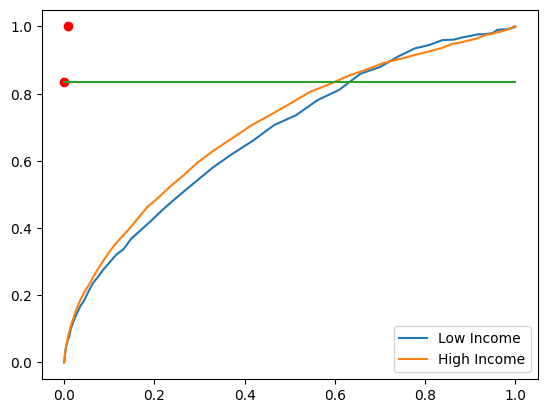

In [246]:
# This is wrong!

plt.plot(fpr_curve0, tpr_curve0, label="Low Income")
plt.plot(fpr_curve1, tpr_curve1, label="High Income")
plt.plot(model_params.x[1], model_params.x[0], 'ro')
plt.plot(model_params.x[3], model_params.x[2], 'ro')
plt.plot(np.linspace(0,1,100), np.ones(100)*model_params.x[0])
plt.legend()